### Aim of this notebook is to predict the forward return of stocks in the S&P 500 Index. To start with, we will simply predict the sign of the return (Positive, Negative, Zero) but can later move on to regression.

# Imports

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Get data

In [2]:
# Get raw data
companies = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_companies.csv")
index = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_index.csv", parse_dates=['Date'])
stocks = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_stocks.csv", parse_dates=['Date'])

In [3]:
companies.head(10)

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,407.57,3028424589312,1.184270e+11,0.176,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.064060
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,166.90,2577253007360,1.301090e+11,0.021,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.054517
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,824.23,2060574916608,3.448000e+10,2.653,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.043587
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,159.92,1977122947072,1.001720e+11,0.135,Mountain View,CA,United States,182502.0,Alphabet Inc. offers various products and plat...,0.041822
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,158.26,1976999608320,1.001720e+11,0.135,Mountain View,CA,United States,182502.0,Alphabet Inc. offers various products and plat...,0.041819
5,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,179.54,1867700764672,8.551500e+10,0.139,Seattle,WA,United States,1525000.0,"Amazon.com, Inc. engages in the retail sale of...",0.039507
6,NMS,META,"Meta Platforms, Inc.","Meta Platforms, Inc.",Communication Services,Internet Content & Information,496.10,1258372464640,6.138100e+10,0.247,Menlo Park,CA,United States,67317.0,"Meta Platforms, Inc. engages in the developmen...",0.026618
7,NYQ,BRK-B,Berkshire Hathaway Inc. New,Berkshire Hathaway Inc.,Financial Services,Insurance - Diversified,408.74,883769475072,1.356820e+11,0.196,Omaha,NE,United States,396500.0,"Berkshire Hathaway Inc., through its subsidiar...",0.018694
8,NYQ,LLY,Eli Lilly and Company,Eli Lilly and Company,Healthcare,Drug Manufacturers - General,745.69,708976705536,1.231460e+10,0.281,Indianapolis,IN,United States,43000.0,"Eli Lilly and Company discovers, develops, and...",0.014997
9,NMS,AVGO,Broadcom Inc.,Broadcom Inc.,Technology,Semiconductors,1249.19,578900852736,2.040400e+10,0.164,Palo Alto,CA,United States,20000.0,"Broadcom Inc. designs, develops, and supplies ...",0.012245


In [4]:
index.head(10)

,Date,S&P500
0,2014-04-24,1878.61
1,2014-04-25,1863.40
2,2014-04-28,1869.43
3,2014-04-29,1878.33
4,2014-04-30,1883.95
5,2014-05-01,1883.68
6,2014-05-02,1881.14
7,2014-05-05,1884.66
8,2014-05-06,1867.72
9,2014-05-07,1878.21


In [5]:
stocks.head(10)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,46.422302,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,46.131523,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,46.785759,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,46.819294,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,47.149204,70.501671,70.501671,69.648827,69.974915,4073337.0
5,2010-01-11,MMM,46.959095,70.217392,70.735786,69.740807,70.551842,3500812.0
6,2010-01-12,MMM,46.998230,70.275917,70.384613,69.648827,69.882942,3626033.0
7,2010-01-13,MMM,46.847260,70.050163,70.326088,69.565216,70.326088,3709992.0
8,2010-01-14,MMM,46.690697,69.816055,70.175583,69.749161,70.016724,3150384.0
9,2010-01-15,MMM,46.618008,69.707359,70.309364,69.289299,69.832779,4730180.0


In [6]:
########################################################
# Join into one wide table which will be our raw dataset
########################################################
# Join index table onto stocks table
df = stocks.merge(
    right=index,
    how='left',
    left_on='Date',
    right_on='Date'
)

# Join companies table onto stocks and index table, dropping some unecessary columns from companies table
df = df.merge(
    right=companies[['Symbol', 'Sector',]],
    how='left',
    left_on='Symbol',
    right_on='Symbol'
)

# Drop dates older than 10 years ago (S&P only provides data with 10 year rolling history)
ten_years_ago = datetime.now() - timedelta(days=365.25*10)
df = df[df['Date'] >= ten_years_ago].reset_index(drop=True)

# Order by date for ease
df.sort_values(
    by='Date',
    inplace=True,
    ignore_index=True
)

In [7]:
df.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Sector
0,2014-04-28,MMM,87.150185,114.740807,115.677261,113.687294,114.908028,2684183.0,1869.43,Industrials
1,2014-04-28,HUM,103.275856,108.970001,109.589996,107.910004,109.540001,1214200.0,1869.43,Healthcare
2,2014-04-28,V,47.597519,50.355000,50.482498,49.752499,49.875000,24263200.0,1869.43,Financial Services
3,2014-04-28,AXP,77.561134,87.059998,87.580002,85.849998,87.440002,4760400.0,1869.43,Financial Services
4,2014-04-28,MET,34.524513,45.418896,45.918003,44.723709,45.864529,9517702.0,1869.43,Financial Services


# EDA

## Column info

In [8]:
# Column types and non-null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265045 entries, 0 to 1265044
Data columns (total 10 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   Date       1265045 non-null  datetime64[ns]
 1   Symbol     1265045 non-null  object        
 2   Adj Close  1231853 non-null  float64       
 3   Close      1231853 non-null  float64       
 4   High       1231853 non-null  float64       
 5   Low        1231853 non-null  float64       
 6   Open       1231853 non-null  float64       
 7   Volume     1231853 non-null  float64       
 8   S&P500     1265045 non-null  float64       
 9   Sector     1262530 non-null  object        
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 96.5+ MB
None


In [9]:
# Distribution of columns
print(df.describe())

                                Date     Adj Close         Close  \
count                        1265045  1.231853e+06  1.231853e+06   
mean   2019-04-23 22:32:58.210735616  1.198396e+02  1.257516e+02   
min              2014-04-28 00:00:00  7.000000e-01  7.000000e-01   
25%              2016-10-21 00:00:00  4.037133e+01  4.535853e+01   
50%              2019-04-25 00:00:00  7.108000e+01  7.778000e+01   
75%              2021-10-21 00:00:00  1.298980e+02  1.375800e+02   
max              2024-04-23 00:00:00  8.099960e+03  8.099960e+03   
std                              NaN  2.301999e+02  2.301562e+02   

               High           Low          Open        Volume        S&P500  
count  1.231853e+06  1.231853e+06  1.231853e+06  1.231853e+06  1.265045e+06  
mean   1.271545e+02  1.242856e+02  1.257309e+02  5.146126e+06  3.104975e+03  
min    7.100000e-01  6.500000e-01  7.000000e-01  0.000000e+00  1.829080e+03  
25%    4.586000e+01  4.483000e+01  4.535000e+01  9.649000e+05  2.177180e+03

## Survivorship bias?

In [10]:
# Check if there is any difference in constituents over time
unique_constituents = stocks.groupby('Date')['Symbol'].unique().reset_index()['Symbol']
first_constituents = unique_constituents[0]
difference = False
for u in unique_constituents:
    if len(u) != len(first_constituents):
        print("Length mismatch")
        difference = True
        break
    elif not all(f == x for f, x in zip(first_constituents, u)):
        print("Constituent mismatch")
        difference = True
        break
print(f"Constituents change over time? {difference}")

Constituents change over time? False


## Plots

<Axes: title={'center': 'Value of S&P 500'}, xlabel='Date'>

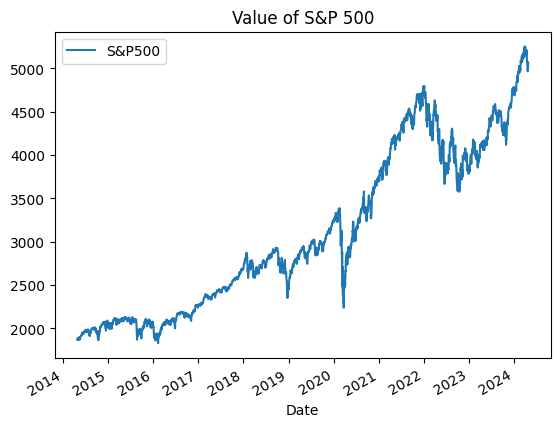

In [11]:
# Plot S&P 500 index value over time
df.plot(x='Date', y='S&P500', title='Value of S&P 500')

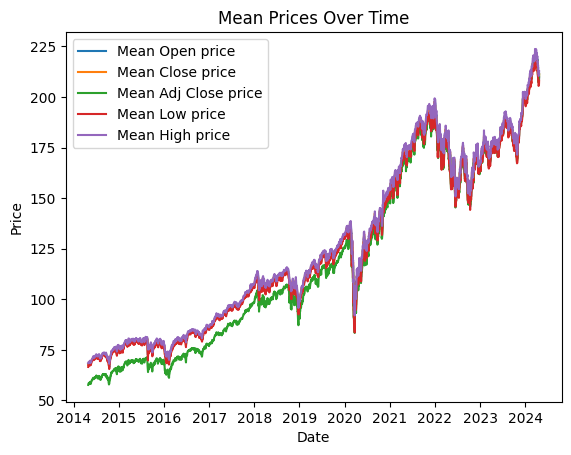

In [12]:
# Plot mean prices over time
mean_open = df.pivot(index='Date', columns='Symbol', values=['Open']).mean(axis=1)
mean_close = df.pivot(index='Date', columns='Symbol', values=['Close']).mean(axis=1)
mean_adj_close = df.pivot(index='Date', columns='Symbol', values=['Adj Close']).mean(axis=1)
mean_low = df.pivot(index='Date', columns='Symbol', values=['Low']).mean(axis=1)
mean_high = df.pivot(index='Date', columns='Symbol', values=['High']).mean(axis=1)
plt.plot(mean_open, label='Mean Open price')
plt.plot(mean_close, label='Mean Close price')
plt.plot(mean_adj_close, label='Mean Adj Close price')
plt.plot(mean_low, label='Mean Low price')
plt.plot(mean_high, label='Mean High price')
plt.title('Mean Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Axes: title={'center': 'Mean Trading Volume of S&P 500 Constituents Over Time'}, xlabel='Date'>

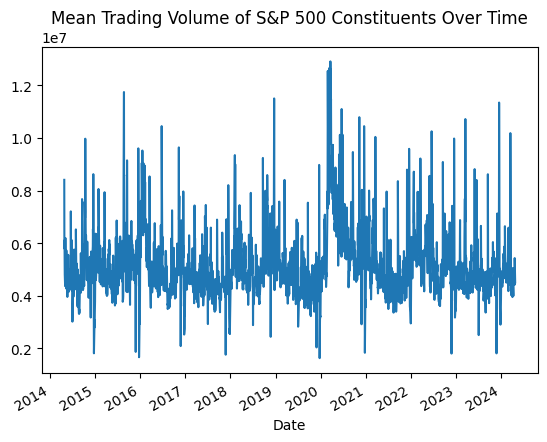

In [13]:
# Plot median trading volume over time
df.pivot(index='Date', columns='Symbol', values='Volume').mean(axis=1).plot(title='Mean Trading Volume of S&P 500 Constituents Over Time')

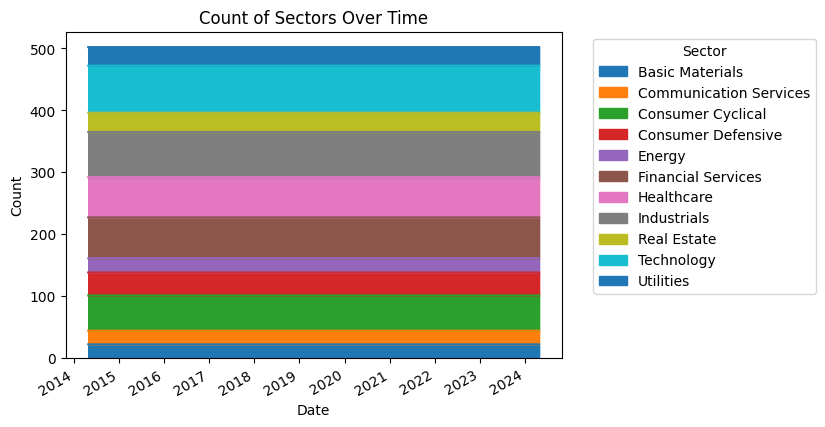

In [14]:
# Plot current sector distribution
sector_counts = df.groupby('Date')['Sector'].value_counts().unstack(fill_value=0)
sector_counts.plot(kind='area')
plt.title('Count of Sectors Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Data cleaning

The first thing to note is that the dataset is all current S&P 500 constituents historically, rather than consituents at the time, so there is some inherent survivorship bias. Also, it turns out that we get data for a ticker when the stock goes public - which is before it enters the index. Before the ticker goes public, we have no pricing data. We can't backfill as this would cause look-ahead bias and doesn't make sense anyway since those stocks wouldn't have had prices. It turns out that if we simply drop all the stocks that don't have pricing data at the start (because they're not listed), this actually removes all the nans in the dataset. This still leaves us with more than 400 names so it's not too bad. If there were any nans we would use forward filling at a stock level to avoid look-ahead bias of linear interpolation.

In [15]:
# Get df of first date 
first_date = df['Date'].min()
mask = df['Date'] == first_date
first_date_df = df[mask]

# Get tickers with no data in numeircal columns at first date
numerical_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'S&P500']
symbols_with_nans = first_date_df[first_date_df[numerical_cols].isnull().any(axis=1)]['Symbol']
symbols_with_nans

# Drop tickers that don't have data at the start
df = df[~df['Symbol'].isin(symbols_with_nans)]

# Print number of names left. Confirm there are no nulls left
print(f"There are {len(df['Symbol'].unique())} tickers remaining")
df.isnull().value_counts()

There are 469 tickers remaining


Date   Symbol  Adj Close  Close  High   Low    Open   Volume  S&P500  Sector
False  False   False      False  False  False  False  False   False   False     1179535
Name: count, dtype: int64

# Feature Engineering

 Do some rankings within sectors over time! e.g. number 1 ranked for best returns last week. Add macro features like rates and yield curve steepness. Oil prices. Dxy to see strength of dollar. Gold.

In [16]:
# One hot encode categorical features
categorical_cols = ['Sector']
df = pd.get_dummies(
    data=df,
    columns=categorical_cols,
    dtype=int
)

df.head(10)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,2014-04-28,MMM,87.150185,114.740807,115.677261,113.687294,114.908028,2684183.0,1869.43,0,0,0,0,0,0,0,1,0,0,0
1,2014-04-28,HUM,103.275856,108.970001,109.589996,107.910004,109.540001,1214200.0,1869.43,0,0,0,0,0,0,1,0,0,0,0
2,2014-04-28,V,47.597519,50.355000,50.482498,49.752499,49.875000,24263200.0,1869.43,0,0,0,0,0,1,0,0,0,0,0
3,2014-04-28,AXP,77.561134,87.059998,87.580002,85.849998,87.440002,4760400.0,1869.43,0,0,0,0,0,1,0,0,0,0,0
4,2014-04-28,MET,34.524513,45.418896,45.918003,44.723709,45.864529,9517702.0,1869.43,0,0,0,0,0,1,0,0,0,0,0
5,2014-04-28,XOM,70.469246,101.169998,101.459999,100.309998,100.720001,12710800.0,1869.43,0,0,0,0,1,0,0,0,0,0,0
6,2014-04-28,PAYX,29.909210,40.680000,40.860001,40.180000,40.669998,1891000.0,1869.43,0,0,0,0,0,0,0,1,0,0,0
7,2014-04-28,CVS,57.048748,73.610001,74.570000,73.250000,73.709999,7684400.0,1869.43,0,0,0,0,0,0,1,0,0,0,0
8,2014-04-28,EBAY,20.684208,22.575758,22.777779,22.285355,22.777779,23105650.0,1869.43,0,0,1,0,0,0,0,0,0,0,0
9,2014-04-28,NKE,32.083363,35.834999,36.845001,35.549999,36.680000,11446800.0,1869.43,0,0,1,0,0,0,0,0,0,0,0


In [17]:
# SMAs, EMAs, Stds. Bollinger bands on the adjusted close and volume
prices = ['Adj Close']
prices_and_volumes = prices + ['Volume']
for day in [5, 12, 20, 26]:
    for p in prices_and_volumes:
        # SMA + EMA
        df[f'{day}-Day SMA {p}'] = df.groupby('Symbol')[p].transform(lambda x: x.rolling(day).mean())
        df[f'{day}-Day EMA {p}']  = df.groupby('Symbol')[p].transform(lambda x: x.ewm(span=day, min_periods=day).mean())
        
        # Standard deviations (volatility)
        df[f'{day}-Day Std {p}'] = df.groupby('Symbol')[p].transform(lambda x: x.rolling(day).std())
        
        # Bollinger bands
        df[f'{day}-Day Upper BB {p}'] = df[f'{day}-Day SMA {p}'] + (2 * df[f'{day}-Day Std {p}'])
        df[f'{day}-Day Lower BB {p}'] = df[f'{day}-Day SMA {p}'] - (2 * df[f'{day}-Day Std {p}'])
        
        # Distance to bollinger bands
        df[f'{p} vs {day}-Day Upper BB'] = df[f'{p}'] - df[f'{day}-Day Upper BB {p}']
        df[f'{p} vs {day}-Day Lower BB'] = df[f'{p}'] - df[f'{day}-Day Lower BB {p}']

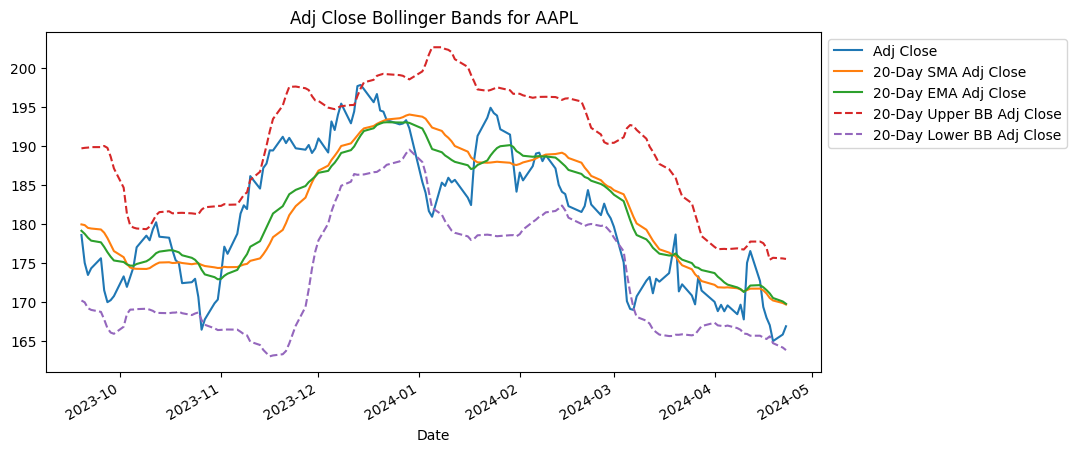

In [18]:
# Plot SMA, EMA and price for AAPL. Note how EMA responds quicker to price swings than SMA
aapl_df = df[df['Symbol'] == 'AAPL'].tail(150)
cols_to_plot = ['Adj Close', '20-Day SMA Adj Close', '20-Day EMA Adj Close', '20-Day Upper BB Adj Close', '20-Day Lower BB Adj Close']
line_styles = {'20-Day Upper BB Adj Close': '--', '20-Day Lower BB Adj Close': '--'}
ax = aapl_df.plot(x ='Date', y=cols_to_plot, figsize=(10, 5), style=line_styles, title='Adj Close Bollinger Bands for AAPL')
ax.legend(bbox_to_anchor=(1, 1))

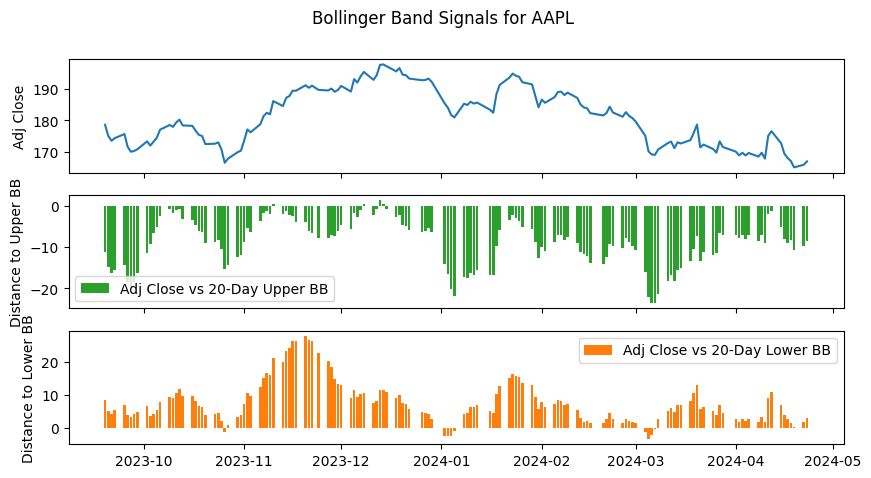

In [19]:
# Plot price vs distance to bollinger bands
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(aapl_df['Date'], aapl_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the BBs and distance to BBs on the second (bottom) subplot
ax2.bar(aapl_df['Date'], aapl_df['Adj Close vs 20-Day Upper BB'], color='tab:green', label='Adj Close vs 20-Day Upper BB')
ax3.bar(aapl_df['Date'], aapl_df['Adj Close vs 20-Day Lower BB'], color='tab:orange', label='Adj Close vs 20-Day Lower BB')
ax2.set_ylabel('Distance to Upper BB')
ax3.set_ylabel('Distance to Lower BB')
ax2.legend()
ax3.legend()
fig.suptitle('Bollinger Band Signals for AAPL')
plt.show()

In [20]:
# MACD https://www.investopedia.com/terms/m/macd.asp
df['MACD'] = df['12-Day EMA Adj Close'] - df['26-Day EMA Adj Close']
df['MACD Signal Line'] = df.groupby('Symbol')['MACD'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
df['MACD Histogram'] = df['MACD'] - df['MACD Signal Line']

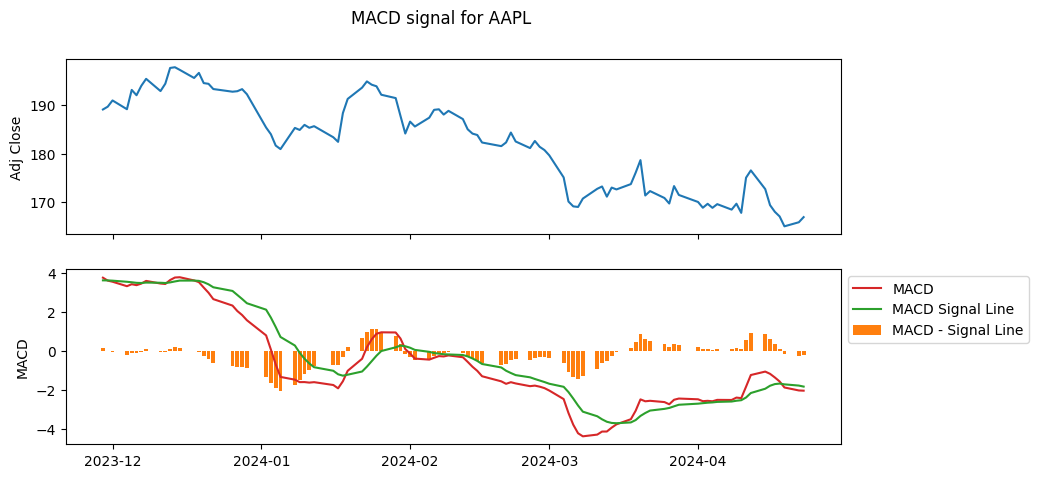

In [21]:
# Plot MACD and MACD Signal for AAPL
aapl_df = df[df['Symbol'] == 'AAPL'].tail(100)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(aapl_df['Date'], aapl_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the MACD line and signal line on the second (bottom) subplot
ax2.plot(aapl_df['Date'], aapl_df['MACD'], color='tab:red', label='MACD')
ax2.plot(aapl_df['Date'], aapl_df['MACD Signal Line'], color='tab:green', label='MACD Signal Line')
ax2.bar(aapl_df['Date'], aapl_df['MACD Histogram'], color='tab:orange', label='MACD - Signal Line')
ax2.set_ylabel('MACD')
ax2.legend(bbox_to_anchor=(1, 1))
fig.suptitle('MACD signal for AAPL')
plt.show()

In [22]:
# Calculate average true range (ATR) which is a measure of volatility
df['High minus Low'] = df['High'] - df['Low']
df['Yesterday Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(1)
df['Abs. High - Yesterday Adj Close'] = (df['High'] - df['Yesterday Adj Close']).abs()
df['Abs. Low - Yesterday Adj Close'] = (df['Low'] - df['Yesterday Adj Close']).abs()
df['True Range'] = df[['High minus Low', 'Abs. High - Yesterday Adj Close', 'Abs. Low - Yesterday Adj Close']].max(axis=1)
df.drop(['High minus Low', 'Abs. High - Yesterday Adj Close', 'Abs. Low - Yesterday Adj Close'], axis=1, inplace=True)
df['26-Day Average True Range'] = df.groupby('Symbol')['True Range'].transform(lambda x: x.rolling(26).mean())

# Calculate MACD-V
df['MACD-V'] = 100 * (df['12-Day EMA Adj Close'] - df['26-Day EMA Adj Close']) / df['26-Day Average True Range']
df['MACD-V Signal Line'] = df.groupby('Symbol')['MACD-V'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
df['MACD-V Histogram'] = df['MACD-V'] - df['MACD-V Signal Line']

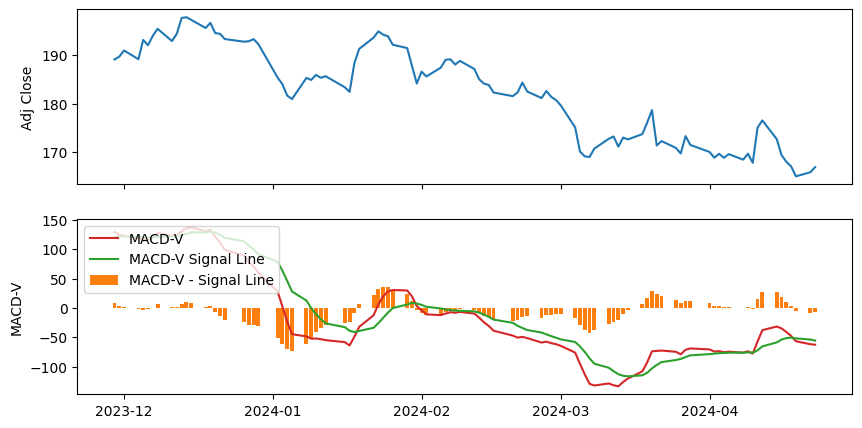

In [23]:
# Plot MACD-V and MACD-V Signal for AAPL
aapl_df = df[df['Symbol'] == 'AAPL'].tail(100)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(aapl_df['Date'], aapl_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the MACD-V line and signal line on the second (bottom) subplot
ax2.plot(aapl_df['Date'], aapl_df['MACD-V'], color='tab:red', label='MACD-V')
ax2.plot(aapl_df['Date'], aapl_df['MACD-V Signal Line'], color='tab:green', label='MACD-V Signal Line')
ax2.bar(aapl_df['Date'], aapl_df['MACD-V Histogram'], color='tab:orange', label='MACD-V - Signal Line')
ax2.set_ylabel('MACD-V')
ax2.legend(loc='upper left')
plt.show()

In [24]:
# Backward returns
for day in range(1, 26, 2):
    df[f'{day}-day Backward Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(day)
    df[f'{day}-day Backward Return'] = (df['Adj Close'] - df[f'{day}-day Backward Adj Close']) / df[f'{day}-day Backward Adj Close']
    df.drop(f'{day}-day Backward Adj Close', axis=1, inplace=True)

In [25]:
# Forward returns
df['3-week Forward Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(-5 * 3)
df['3-week Forward S&P Value'] = df.groupby('Symbol')['S&P500'].shift(-5 * 3)
df['3-week Forward S&P Return'] = (df['3-week Forward S&P Value'] - df['S&P500']) / df['S&P500']
df['3-week Forward Return'] = (df['3-week Forward Adj Close'] - df['Adj Close']) / df['Adj Close']
df['3-week Forward Excess Return'] = df['3-week Forward Return'] - df['3-week Forward S&P Return']

# Create targets from forward returns (sign of return)
df['3-week Forward Excess Return Sign'] = np.sign(df['3-week Forward Excess Return'])
df.drop(['3-week Forward Adj Close', '3-week Forward S&P Value', '3-week Forward S&P Return', '3-week Forward Return', '3-week Forward Excess Return'], axis=1, inplace=True)

# Replace symbol with stock id
df['Symbol'] = df['Symbol'].rank(method='dense', ascending=False).astype(int)

# Replace date with unique date ID
df['Date'] = df['Date'].rank(method='dense', ascending=True).astype(int)

In [26]:
df.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Sector_Basic Materials,...,9-day Backward Return,11-day Backward Return,13-day Backward Return,15-day Backward Return,17-day Backward Return,19-day Backward Return,21-day Backward Return,23-day Backward Return,25-day Backward Return,3-week Forward Excess Return Sign
0,1,180,87.150185,114.740807,115.677261,113.687294,114.908028,2684183.0,1869.43,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,251,103.275856,108.970001,109.589996,107.910004,109.540001,1214200.0,1869.43,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1,32,47.597519,50.355000,50.482498,49.752499,49.875000,24263200.0,1869.43,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1,423,77.561134,87.059998,87.580002,85.849998,87.440002,4760400.0,1869.43,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1,188,34.524513,45.418896,45.918003,44.723709,45.864529,9517702.0,1869.43,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1179535 entries, 0 to 1265044
Data columns (total 99 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Date                               1179535 non-null  int64  
 1   Symbol                             1179535 non-null  int64  
 2   Adj Close                          1179535 non-null  float64
 3   Close                              1179535 non-null  float64
 4   High                               1179535 non-null  float64
 5   Low                                1179535 non-null  float64
 6   Open                               1179535 non-null  float64
 7   Volume                             1179535 non-null  float64
 8   S&P500                             1179535 non-null  float64
 9   Sector_Basic Materials             1179535 non-null  int64  
 10  Sector_Communication Services      1179535 non-null  int64  
 11  Sector_Consumer Cyclical     

In [28]:
# Write to file
#df.to_csv(path_or_buf="all_data.csv")